In [1]:
import os
import pickle

import geopandas as gpd
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import polars
import polars as pl
import pyvisgraph as vg
from shapely import unary_union, wkt
from tqdm import tqdm

In [2]:
def create_grid_visualization(df):
    # グリッドの次元を取得
    x_max = df["grid_x"].max() + 1
    y_max = df["grid_y"].max() + 1

    # 2D配列に変換
    grid = np.zeros((y_max, x_max))
    for row in df.iter_rows():
        x, y, cost = row
        grid[y, x] = cost

    # プロットの作成
    plt.figure(figsize=(12, 8))

    # pcolormeshでヒートマップを描画
    im = plt.pcolormesh(grid, cmap="viridis", shading="auto")

    # カラーバーを追加

    plt.colorbar(im, label="Cost(分)")

    # 軸ラベルを設定
    plt.xlabel("Grid X")
    plt.ylabel("Grid Y")
    plt.title("Tobler's hiking function")

    # グリッドを表示
    plt.grid(True)

    return plt

In [3]:
def get_site_grid_coords(
    df_obsidian: pl.DataFrame, df_elevation: pl.DataFrame
) -> np.ndarray:
    """
    遺跡の座標をグリッド座標に変換

    Parameters
    ----------
    df_obsidian : pl.DataFrame
        遺跡のデータフレーム
    df_elevation : pl.DataFrame
        標高のデータフレーム

    Returns
    -------
    np.ndarray
        遺跡のグリッド座標
    """

    x_spacing = df_elevation["x"].unique().sort().diff().mode()[0]
    y_spacing = df_elevation["y"].unique().sort().diff().mode()[0]
    x_first_center = df_elevation["x"].min()
    y_first_center = df_elevation["y"].min()

    coords = (
        df_obsidian.select([(pl.col("遺跡ID")), (pl.col("緯度")), (pl.col("経度"))])
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
        .with_columns(
            [
                ((pl.col("経度") - (x_first_center - (x_spacing / 2))) / x_spacing)
                .cast(pl.Int64)
                .alias("grid_x"),
                ((pl.col("緯度") - (y_first_center - (y_spacing / 2))) / y_spacing)
                .cast(pl.Int64)
                .alias("grid_y"),
            ]
        )
    )

    site_grid_coords = np.column_stack(
        [coords["grid_x"].to_numpy(), coords["grid_y"].to_numpy()]
    )

    return site_grid_coords

In [4]:
SCHEMA = pl.Schema(
    {
        "grid_x": pl.Int64,
        "x": pl.Float64,
        "grid_y": pl.Int64,
        "y": pl.Float64,
        "mesh_code_5th": pl.Int64,
        "average_elevation": pl.Float64,
        "maximum_elevation": pl.Float64,
        "minimum_elevation": pl.Float64,
        "minimum_elevation_code": pl.Int64,
        "maximum_slope_angle": pl.Float64,
        "maximum_slope_direction": pl.Int64,
        "minimum_slope_angle": pl.Float64,
        "minimum_slope_direction": pl.Int64,
        "average_slope_angle": pl.Float64,
        "geometry": pl.Utf8,
        "is_sea": pl.Boolean,
        "walking_velocity": pl.Float64,
        "travel_time": pl.Float64,
        "elevation_diff_east": pl.Float64,
        "angle_east": pl.Float64,
        "walking_velocity_east": pl.Float64,
        "travel_time_east": pl.Float64,
        "elevation_diff_west": pl.Float64,
        "angle_west": pl.Float64,
        "walking_velocity_west": pl.Float64,
        "travel_time_west": pl.Float64,
        "elevation_diff_north": pl.Float64,
        "angle_north": pl.Float64,
        "walking_velocity_north": pl.Float64,
        "travel_time_north": pl.Float64,
        "elevation_diff_south": pl.Float64,
        "angle_south": pl.Float64,
        "walking_velocity_south": pl.Float64,
        "travel_time_south": pl.Float64,
        "cost_kouzu": pl.Float64,
        "cost_shinshu": pl.Float64,
        "cost_hakone": pl.Float64,
        "cost_takahara": pl.Float64,
        "cost_river": pl.Float64,
        "x_meter": pl.Float64,
        "y_meter": pl.Float64,
    }
)

data_dir = "/home/ohta/dev/bayesian_statistics/data/"

df_elevation = pl.read_csv(
    os.path.join(data_dir, "11_gdf_elevation.csv"),
    null_values=["nan"],  # "nan"をnullとして扱う
)
df_elevation = (
    # データ型を変換
    df_elevation.cast(SCHEMA)
    # 全く欠損していない行をis_validとする
    .with_columns(
        [
            pl.all_horizontal(
                [~pl.col(col).is_null() for col in df_elevation.columns]
            ).alias("is_valid")
        ]
    )
)

df_obsidian = pl.read_csv(os.path.join(data_dir, "11_gdf_obsidian.csv"))
df_sites = pl.read_csv(os.path.join(data_dir, "11_gdf_sites.csv"))

site_grid_coords = get_site_grid_coords(df_obsidian, df_elevation)

/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


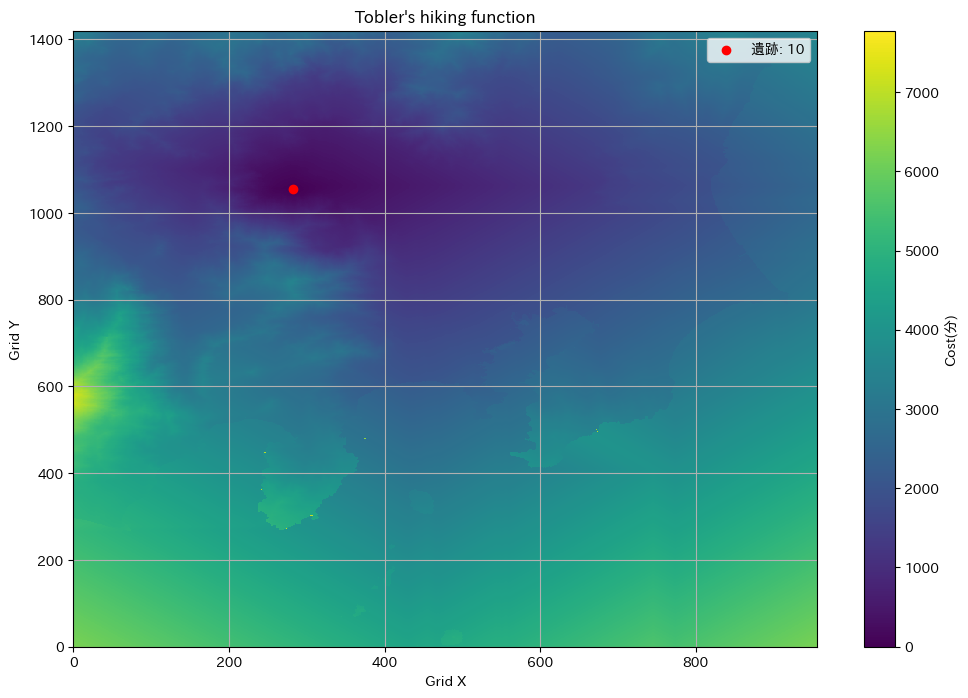

In [5]:
i = 10

x = site_grid_coords[i, 0]
y = site_grid_coords[i, 1]

### pickleで保存したファイルを読み込み
with open(
    os.path.join(
        data_dir, "16_tobler_distance_with_coast_50_average", f"distance_siteID_{i}"
    ),
    mode="br",
) as fi:
    min_costs = pickle.load(fi)

width = 956
height = 1420

# grid_x, grid_y, min_cost_minutsという列を持つpl.DataFrameを作成
min_costs_df = pl.DataFrame(
    {
        "grid_x": np.tile(np.arange(width), height),
        "grid_y": np.repeat(np.arange(height), width),
        f"cost_{i}": min_costs,
    }
)

# 使用例:
plt_ = create_grid_visualization(min_costs_df)
plt_.scatter(x, y, color="red", label=f"遺跡: {i}")
plt_.legend()
plt_.show()

### 説明変数を入れてカーネル回帰とIPPを同時推定

In [6]:
import os
from typing import Tuple

import numpy as np
import polars as pl

In [7]:
# 地点ごとの産地構成比を計算


def preprocess_data(
    df: pl.DataFrame, target_period: int, target_origin: str
) -> Tuple[np.ndarray, np.ndarray]:
    """
    解析用のデータを前処理

    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム
    target_period : int
        対象時期
    target_origin : str
        対象産地カテゴリ

    Returns
    -------
    counts : np.ndarray
        各遺跡での出土数（インデックスが遺跡ID）
    target_counts : np.ndarray
        対象産地の出土数（インデックスが遺跡ID）
    """
    # 全遺跡IDのリストを取得
    max_site_id = df["遺跡ID"].max()

    # 対象時期のデータのみ抽出
    period_df = df.filter(pl.col("時期") == target_period)

    # 全体のカウント
    counts = (
        period_df.group_by("遺跡ID")
        .agg([pl.len().alias("count")])
        .join(
            pl.DataFrame({"遺跡ID": np.arange(max_site_id + 1)}),
            on="遺跡ID",
            how="right",
        )
        .fill_null(0)
        .sort("遺跡ID")["count"]
        .to_numpy()
    )

    # 対象産地のカウント
    target_counts = (
        period_df.filter(pl.col("産地カテゴリ") == target_origin)
        .group_by("遺跡ID")
        .agg([pl.len().alias("count")])
        .join(
            pl.DataFrame({"遺跡ID": np.arange(max_site_id + 1)}),
            on="遺跡ID",
            how="right",
        )
        .fill_null(0)
        .sort("遺跡ID")["count"]
        .to_numpy()
    )

    return counts, target_counts

In [8]:
def create_site_coords(df: pl.DataFrame) -> np.ndarray:
    """
    遺跡の座標をラジアンに変換

    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム

    Returns
    -------
    np.ndarray
        遺跡の座標（ラジアン）
    """
    # 座標をラジアンに変換
    coords = (
        df.select(
            [
                (pl.col("遺跡ID")),
                (pl.col("緯度") * np.pi / 180).alias("lat_rad"),
                (pl.col("経度") * np.pi / 180).alias("lon_rad"),
            ]
        )
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
    )

    # 座標と出土数を numpy 配列に変換
    site_coords = np.column_stack(
        [coords["lat_rad"].to_numpy(), coords["lon_rad"].to_numpy()]
    )

    return site_coords

In [9]:
def get_site_grid_coords(
    df_obsidian: pl.DataFrame, df_elevation: pl.DataFrame
) -> np.ndarray:
    """
    遺跡の座標をグリッド座標に変換

    Parameters
    ----------
    df_obsidian : pl.DataFrame
        遺跡のデータフレーム
    df_elevation : pl.DataFrame
        標高のデータフレーム

    Returns
    -------
    np.ndarray
        遺跡のグリッド座標
    """

    x_spacing = df_elevation["x"].unique().sort().diff().mode()[0]
    y_spacing = df_elevation["y"].unique().sort().diff().mode()[0]
    x_first_center = df_elevation["x"].min()
    y_first_center = df_elevation["y"].min()

    coords = (
        df_obsidian.select([(pl.col("遺跡ID")), (pl.col("緯度")), (pl.col("経度"))])
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
        .with_columns(
            [
                ((pl.col("経度") - (x_first_center - (x_spacing / 2))) / x_spacing)
                .cast(pl.Int64)
                .alias("grid_x"),
                ((pl.col("緯度") - (y_first_center - (y_spacing / 2))) / y_spacing)
                .cast(pl.Int64)
                .alias("grid_y"),
            ]
        )
    )

    site_grid_coords = np.column_stack(
        [coords["grid_x"].to_numpy(), coords["grid_y"].to_numpy()]
    )

    return site_grid_coords

In [10]:
# 重みの初期計算
def K(x, sigma):
    return np.exp(-0.5 * (x**2) / (sigma**2)) / (2 * np.pi * sigma**2)


def calculate_weights_matrix(
    grid_coords: np.ndarray,  # (グリッド数, 2)
    site_coords: np.ndarray,  # (遺跡数, 2)
    sigma: float,
) -> np.ndarray:  # (グリッド数, 遺跡数)
    """
    重み行列を計算
    """
    R = 6371  # 地球の半径(km)

    # 通常の距離計算
    dlat = grid_coords[:, np.newaxis, 0] - site_coords[np.newaxis, :, 0]
    dlon = grid_coords[:, np.newaxis, 1] - site_coords[np.newaxis, :, 1]

    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(grid_coords[:, np.newaxis, 0])
        * np.cos(site_coords[np.newaxis, :, 0])
        * np.sin(dlon / 2) ** 2
    )

    distances = 2 * R * np.arcsin(np.sqrt(a))

    weights = K(distances, sigma)

    return weights

In [11]:
def calculate_distance_W(
    W_grid: np.ndarray,
    W_sites: np.ndarray,
) -> np.ndarray:
    """
    説明変数間の距離行列を計算

    Parameters
    ----------
    W_grid : np.ndarray
        グリッドの説明変数 (グリッド数, p)
    W_sites : np.ndarray
        遺跡の説明変数 (遺跡数, p)

    p は説明変数の次元数

    Returns
    -------
    np.ndarray
        説明変数間の距離行列 (グリッド数, 遺跡数, p)
    """
    # W_gridを(グリッド数, 1, p)に、W_sitesを(1, 遺跡数, p)に reshape
    # ブロードキャストにより自動的に(グリッド数, 遺跡数, p)に拡張される
    W_grid_expanded = W_grid[:, np.newaxis, :]
    W_sites_expanded = W_sites[np.newaxis, :, :]

    # ユークリッド距離の計算
    distances = np.abs(W_grid_expanded - W_sites_expanded)

    return distances

In [12]:
def create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh):
    # 地形マスクの作成
    land_points = df_elevation.select(
        ["x", "y", pl.col("is_sea").cast(pl.Boolean)]
    ).to_numpy()

    lons_1d = lon_mesh[0, :]
    lats_1d = lat_mesh[:, 0]
    land_mask = np.full(lon_mesh.shape, False)

    x_indices = np.searchsorted(lons_1d, land_points[:, 0])
    y_indices = np.searchsorted(lats_1d, land_points[:, 1])
    valid_points = (
        (x_indices > 0)
        & (x_indices < len(lons_1d))
        & (y_indices > 0)
        & (y_indices < len(lats_1d))
    )
    is_sea = land_points[valid_points, 2].astype(bool)
    land_mask[y_indices[valid_points], x_indices[valid_points]] = ~is_sea

    # grid_coordsの各点について、対応するland_maskの値を取得
    grid_lons = grid_coords[:, 1] * 180 / np.pi  # ラジアンから度に変換
    grid_lats = grid_coords[:, 0] * 180 / np.pi

    grid_x_indices = np.searchsorted(lons_1d, grid_lons)
    grid_y_indices = np.searchsorted(lats_1d, grid_lats)

    # インデックスが有効範囲内にあることを確認
    valid_grid_points = (
        (grid_x_indices > 0)
        & (grid_x_indices < len(lons_1d))
        & (grid_y_indices > 0)
        & (grid_y_indices < len(lats_1d))
    )

    # 海上の点の重みを0に設定
    grid_is_land = np.zeros(len(grid_coords), dtype=bool)
    grid_is_land[valid_grid_points] = land_mask[
        grid_y_indices[valid_grid_points], grid_x_indices[valid_grid_points]
    ]

    return grid_is_land

In [13]:
def calculate_ratios(
    weights: np.ndarray, counts: np.ndarray, target_counts: np.ndarray
) -> np.ndarray:
    """
    重み付き比率を計算

    Parameters
    ----------
    weights : np.ndarray
        重み行列
    counts : np.ndarray
        各遺跡での出土数
    target_counts : np.ndarray
        対象産地の出土数

    Returns
    -------
    ratios : np.ndarray
        各グリッド点での重み付き比率
    """
    # 重み付き合計を計算
    weighted_total = np.sum(weights * counts, axis=1)
    weighted_target = np.sum(weights * target_counts, axis=1)

    # 比率計算（0除算を防ぐ）
    ratios = np.where(weighted_total > 0, weighted_target / weighted_total, 0)

    return ratios

In [14]:
def plot_contour(
    df,
    x_col="x",
    y_col="y",
    value_col="cost_kouzu",
    figsize=(12, 8),
    plot_probability=False,
    n_levels=30,
    cmap="Blues",
):
    # まず海陸判定のマスクを作成
    mask = df.with_columns((~pl.col("is_sea")).alias("is_not_sea")).pivot(
        values="is_not_sea", on=x_col, index=y_col
    )

    # 値のピボットテーブルを作成
    grid_data = df.pivot(values=value_col, on=x_col, index=y_col)

    # マスクを適用（y_col列は保持）
    grid_data = grid_data.with_columns(
        [
            pl.col(col) * mask.get_column(col)
            for col in grid_data.columns
            if col != y_col
        ]
    )

    # メッシュグリッドの作成
    x_mesh = np.array(grid_data.columns[1:], dtype=float)
    y_mesh = np.array(grid_data.to_numpy()[:, 0], dtype=float)
    values_mesh = grid_data.to_numpy()[:, 1:]

    # プロット作成
    fig, ax = plt.subplots(figsize=figsize)

    if plot_probability:
        # 確率表示モード（0-1の範囲）
        contour = ax.contourf(
            x_mesh,
            y_mesh,
            values_mesh,
            levels=np.linspace(0, 1, n_levels + 1),
            cmap=cmap,
            alpha=0.7,
            vmin=0,
            vmax=1,
        )
    else:
        # 通常モード（データをそのまま使用）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh, levels=n_levels, cmap=cmap, alpha=0.7
        )

    # カラーバーの追加
    if plot_probability:
        # カラーバー（0-1の範囲に固定）
        plt.colorbar(contour, ax=ax, label="Ratio", ticks=np.linspace(0, 1, 6))
    else:
        plt.colorbar(contour, ax=ax)

    # ラベルの設定
    ax.set_xlabel("経度")
    ax.set_ylabel("緯度")

    return fig, ax

In [15]:
SCHEMA = pl.Schema(
    {
        "grid_x": pl.Int64,
        "x": pl.Float64,
        "grid_y": pl.Int64,
        "y": pl.Float64,
        "mesh_code_5th": pl.Int64,
        "average_elevation": pl.Float64,
        "maximum_elevation": pl.Float64,
        "minimum_elevation": pl.Float64,
        "minimum_elevation_code": pl.Int64,
        "maximum_slope_angle": pl.Float64,
        "maximum_slope_direction": pl.Int64,
        "minimum_slope_angle": pl.Float64,
        "minimum_slope_direction": pl.Int64,
        "average_slope_angle": pl.Float64,
        "geometry": pl.Utf8,
        "is_sea": pl.Boolean,
        "walking_velocity": pl.Float64,
        "travel_time": pl.Float64,
        "elevation_diff_east": pl.Float64,
        "angle_east": pl.Float64,
        "walking_velocity_east": pl.Float64,
        "travel_time_east": pl.Float64,
        "elevation_diff_west": pl.Float64,
        "angle_west": pl.Float64,
        "walking_velocity_west": pl.Float64,
        "travel_time_west": pl.Float64,
        "elevation_diff_north": pl.Float64,
        "angle_north": pl.Float64,
        "walking_velocity_north": pl.Float64,
        "travel_time_north": pl.Float64,
        "elevation_diff_south": pl.Float64,
        "angle_south": pl.Float64,
        "walking_velocity_south": pl.Float64,
        "travel_time_south": pl.Float64,
        "cost_kouzu": pl.Float64,
        "cost_shinshu": pl.Float64,
        "cost_hakone": pl.Float64,
        "cost_takahara": pl.Float64,
        "cost_river": pl.Float64,
        "x_meter": pl.Float64,
        "y_meter": pl.Float64,
    }
)

In [16]:
data_dir = "/home/ohta/dev/bayesian_statistics/data/"

df_elevation = pl.read_csv(
    os.path.join(data_dir, "11_gdf_elevation.csv"),
    null_values=["nan"],  # "nan"をnullとして扱う
)
df_elevation = (
    # データ型を変換
    df_elevation.cast(SCHEMA)
    # 全く欠損していない行をis_validとする
    .with_columns(
        [
            pl.all_horizontal(
                [~pl.col(col).is_null() for col in df_elevation.columns]
            ).alias("is_valid")
        ]
    )
)

df_obsidian = pl.read_csv(os.path.join(data_dir, "11_gdf_obsidian.csv"))
df_sites = pl.read_csv(os.path.join(data_dir, "11_gdf_sites.csv"))

time_period_name = {0: "早期・早々期", 1: "前期", 2: "中期", 3: "後期", 4: "晩期"}

origin_order = ["神津島", "信州", "箱根", "高原山", "その他"]

sigma = 500
sigma_for_sites = 0.1

# =======================================================================================

# メッシュグリッドを作成
lon_mesh, lat_mesh = np.meshgrid(
    df_elevation["x"].unique().sort(),  # 経度の一意な値
    df_elevation["y"].unique().sort(),  # 緯度の一意な値
)

print(lon_mesh.shape, lat_mesh.shape)

# 遺跡の位置: (遺跡数, 2)
site_coords = create_site_coords(df_obsidian)

# グリッドの位置座標: (グリッド数, 2)
grid_coords = np.column_stack(
    [lat_mesh.ravel() * np.pi / 180, lon_mesh.ravel() * np.pi / 180]
)

(1420, 956) (1420, 956)


In [17]:
df_sites = df_sites.join(
    df_elevation.drop(["x", "y"]).with_columns(
        [pl.col("mesh_code_5th").cast(pl.Int64).alias("mesh_code_5th")]
    ),
    left_on="メッシュコード",
    right_on="mesh_code_5th",
    how="left",
)

## 説明変数を入れたcoordsを作成する

In [18]:
# 説明変数の一覧
variable_names = [
    "average_elevation",
    "average_slope_angle",
    "cost_kouzu",
    "cost_shinshu",
    "cost_hakone",
    "cost_takahara",
    "cost_river",
]

# grid_coordsに対応する形で説明変数を取得: (グリッド数, p)
W_grids = (
    df_elevation.sort(["y", "x"]).select(variable_names).to_numpy().astype(np.float64)
)

# site_coordsに対応する形で説明変数を取得: (遺跡数, p)
W_sites = df_sites.sort("遺跡ID").select(variable_names).to_numpy().astype(np.float64)

In [19]:
# ====================
# 距離行列を読み込む
# ====================

# 距離行列の読み込み
### pickleで保存したファイルを読み込み

# distances = np.zeros((len(grid_coords), len(site_coords)))
# for i in range(len(site_coords)):
#    with open(os.path.join(data_dir, "16_tobler_distance_with_coast_50_average", f"distance_siteID_{i}"), mode='br') as fi:
#        min_costs = pickle.load(fi)
#        distances[:, i] = min_costs

In [20]:
# ====================
# 重み行列を計算
# ====================

# weights = K(distances, sigma)

In [21]:
# print("creating weights matrix...")
# 陸地のみの重み行列の計算
# weights = calculate_weights_matrix(
#    grid_coords, site_coords, sigma
# )

# 説明変数間の距離行列の計算
# print("calculating distance_W...")
# distance_W = calculate_distance_W(W_grids, W_sites)

# weights_W = K(distance_W, sigma).prod(axis=2)

# weights *= weights_W

# print("updating weights matrix...")

# 重みの更新
# grid_is_land = create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh)

# 海上の点からの重みをすべて0に
# weights *= grid_is_land[:, np.newaxis]

# 遺跡についての計算 ============================================================================

# 遺跡の一意な地点を取得
unique_sites = df_obsidian.unique(subset=["遺跡ID"]).sort("遺跡ID")

# 計算対象の遺跡の座標をラジアンに変換
# target_coords_sites = np.column_stack([
#    unique_sites['緯度'].to_numpy() * np.pi / 180,
#    unique_sites['経度'].to_numpy() * np.pi / 180
# ])

In [22]:
# ============================
# sites同士の距離行列を計算
# ============================

# site_grid_coords = get_site_grid_coords(df_obsidian, df_elevation)

# def idx(x, y):
#    return y * width + x

# distancesは(グリッド数, 遺跡数)の形状なので、i=idx(site_grid_coords)として、distances[i]をスライスすれば、(遺跡数, 遺跡数)の形状になる
# site_grid_idx = np.vectorize(idx)(site_grid_coords[:, 0], site_grid_coords[:, 1])

# distances_sites = distances[site_grid_idx]
# weights_sites = K(distances_sites, sigma_for_sites)

In [23]:
# weights.shape, weights_sites.shape

In [24]:
# ------------------------------------------------------------------------------------
# Cell 7 : 可視化
# ------------------------------------------------------------------------------------


def plot_result(
    pi_grid,
    target_origin_idx,
    df_elevation=df_elevation,
    df_sites=df_sites,
    target_period=0,
    plot_probability=True,
    cmap="Blues",
    title=None,
):
    # counts_allをaxis=1方向で正規化して、ratio_trueを作成
    ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)
    # ratio_trueのNaNを0に置き換え
    ratio_true = np.nan_to_num(ratio_true)

    ratio_sites_df = pl.DataFrame({"遺跡ID": df_sites["遺跡ID"]})

    for i, target_origin in enumerate(origin_order[:-1]):
        ratio_sites_df = ratio_sites_df.join(
            pl.DataFrame(
                {
                    "遺跡ID": unique_sites["遺跡ID"],
                    f"比率_{target_period}_{target_origin}": ratio_true[:, i],
                }
            ),
            on="遺跡ID",
        )
        if f"比率_{target_period}_{target_origin}" in df_sites.columns:
            df_sites = df_sites.drop(f"比率_{target_period}_{target_origin}")
        if f"比率_{target_period}_{target_origin}_right" in df_sites.columns:
            df_sites = df_sites.drop(f"比率_{target_period}_{target_origin}_right")

    df_sites = df_sites.join(ratio_sites_df, on="遺跡ID")

    ratio_df = pl.DataFrame({"x": lon_mesh.ravel(), "y": lat_mesh.ravel()})

    target_period = 0
    target_origin = origin_order[target_origin_idx]

    print(f"target_period: {target_period}, target_origin: {target_origin}")

    # ここからtarget_period, target_originに依存する処理

    ratio_mesh = pi_grid[:, target_origin_idx].reshape(lon_mesh.shape)

    ratio_df = ratio_df.join(
        pl.DataFrame(
            {
                "x": lon_mesh.ravel(),
                "y": lat_mesh.ravel(),
                f"ratio_{target_period}_{target_origin}": ratio_mesh.ravel(),
            }
        ),
        on=["x", "y"],
    )

    if f"ratio_{target_period}_{target_origin}" in df_elevation.columns:
        df_elevation = df_elevation.drop([f"ratio_{target_period}_{target_origin}"])

    if f"ratio_{target_period}_{target_origin}_right" in df_elevation.columns:
        df_elevation = df_elevation.drop(
            [f"ratio_{target_period}_{target_origin}_right"]
        )
    df_elevation = df_elevation.join(ratio_df, on=["x", "y"])

    fig, ax = plot_contour(
        df_elevation,
        value_col=f"ratio_{target_period}_{target_origin}",
        plot_probability=plot_probability,
        cmap=cmap,
    )

    boundary_df = df_elevation.filter(
        pl.col("is_sea") == 0, pl.col("average_elevation").is_null()
    )

    ax.scatter(boundary_df["x"], boundary_df["y"], c="black", s=0.001)

    ax.scatter(
        df_sites["経度"],
        df_sites["緯度"],
        c=df_sites[f"比率_{target_period}_{target_origin}"],
        cmap="Blues",
        edgecolors="black",
        linewidths=0.5,
        vmin=0,
        vmax=1,
    )

    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(
            f"黒曜石の産地構成比 ({time_period_name[target_period]}, {target_origin})"
        )

    return fig, ax

In [25]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import beta, dirichlet


# ------------------------------------------------------------------
# 0.  前処理 : 共変量を z-score し X = [coords | cov_z] を生成
# ------------------------------------------------------------------
def build_design_matrices(site_coords, W_sites, grid_coords, W_grids):
    """
    Returns
    -------
    X_sites  : (N,9)
    X_grids  : (M,9)
    mu_z, sd_z : z-score パラメータ（再利用用）
    """
    mu_z = W_sites.mean(0)
    sd_z = W_sites.std(0, ddof=0)
    W_sites_z = (W_sites - mu_z) / sd_z
    W_grids_z = (W_grids - mu_z) / sd_z
    return (
        np.hstack([site_coords, W_sites_z]),
        np.hstack([grid_coords, W_grids_z]),
        mu_z,
        sd_z,
    )


# ------------------------------------------------------------------
# 1. ARD Gaussian kernel  (9-dim All-in-one)
# ------------------------------------------------------------------
def ard_kernel(X1, X2, ell):
    """
    ell : length-scale array shape (9,)
    """
    diff2 = (X1[:, None, :] - X2[None, :, :]) ** 2 / (ell**2)
    return np.exp(-0.5 * diff2.sum(-1))  # (n1,n2)


# ------------------------------------------------------------------
# 2. utility
# ------------------------------------------------------------------
def _log_multinom(counts, probs, eps=1e-20):
    return np.sum(counts * np.log(probs + eps), axis=-1)


def _compute_pi(psi):
    psi = np.clip(psi, 1e-300, 1 - 1e-16)
    cum = np.cumprod(1 - psi, axis=1)
    pi = psi.copy()
    if pi.shape[1] > 1:
        pi[:, 1:] *= cum[:, :-1]
    return pi


# ------------------------------------------------------------------
# 3. main trainer
# ------------------------------------------------------------------
def train_ddp(
    X_sites,
    Y,
    X_grids=None,
    N=None,
    ell=None,  # length-scales (9,)
    gamma=1.0,
    alpha0=0.1,
    J_max=100,
    n_iter=500,
    burnin=100,
    thin=1,
    sigma_phi=0.05,
    sigma_v=0.3,
    seed=0,
):
    """
    Train KSBP with 9-dim ARD kernel.
    X_sites : (N,9) = [coord, cov_z]
    X_grids : (M,9)  予測域（φ の初期 & 制約に使う）
    ell     : np.array(9,)  各次元の長さ尺度
    """
    rng = default_rng(seed)
    Nsites, dim = X_sites.shape
    p_cov = dim - 2
    K = Y.shape[1]
    if N is None:
        N = Y.sum(1)
    if ell is None:  # 共通初期値
        ell = np.array([0.01, 0.01] + [1.0] * p_cov)

    if X_grids is None:
        X_grids = X_sites
    mins, maxs = X_grids.min(0), X_grids.max(0)

    # --- 初期 φ はグリッドからランダム抽出 -------------------------

    grid_coords = X_grids[:, :2]  # (M,2)
    idx_sp = rng.choice(len(grid_coords), J_max, replace=True)
    phi = np.empty((J_max, dim))
    # (a) 空間 2 次元は格子点からそのまま
    phi[:, :2] = grid_coords[idx_sp]

    # (b) 共変量 p_cov 次元は W_grids_z の min–max 一様
    cov_z = X_grids[:, 2:]  # (M,p_cov) — すでに z-score 済み
    low = np.nanmin(cov_z, 0)
    high = np.nanmax(cov_z, 0)
    phi[:, 2:] = rng.uniform(low, high, size=(J_max, p_cov))

    v = beta.rvs(1, gamma, size=J_max, random_state=rng)
    theta = dirichlet.rvs([alpha0 / K] * K, size=J_max, random_state=rng)
    z = rng.integers(J_max, size=Nsites)
    u = rng.uniform(0, 0.5, size=Nsites)

    n_store = (n_iter - burnin) // thin
    phi_tr = np.empty((n_store, J_max, dim))
    v_tr = np.empty((n_store, J_max))
    theta_tr = np.empty((n_store, J_max, K))
    trace_k = []
    s_ix = 0

    for it in tqdm(range(n_iter)):
        Kmat = ard_kernel(X_sites, phi, ell)  # (N,J)
        # 1) psi 計算は同じ
        psi = v * Kmat  # (N,J)
        pi = _compute_pi(psi)

        # --- Z Gibbs
        lp = np.log(pi) + _log_multinom(Y[:, None, :], theta[None, :, :])
        pz = np.exp(lp - lp.max(1, keepdims=True))
        pz /= pz.sum(1, keepdims=True)
        z = np.array([rng.choice(J_max, p=pz[i]) for i in range(Nsites)])

        # --- slice
        u = rng.uniform(0, pi[np.arange(Nsites), z])
        L = int((np.cumsum(psi, 1) < (1 - u.min())).any(0).sum()) + 1
        L = min(max(L, 3), J_max)
        active = slice(0, L)

        # --- θ Dirichlet
        for h in range(L):
            y_sum = Y[z == h].sum(0)
            theta[h] = rng.dirichlet(
                alpha0 / K + y_sum if y_sum.any() else [alpha0 / K] * K
            )

        # --- v 共役 Beta
        m = np.array([(z == h).sum() for h in range(L)])
        bmask = u[:, None] < psi[:, active]
        r = np.array([(bmask[:, h] & (z > h)).sum() for h in range(L)])
        v[active] = beta.rvs(1 + m, gamma + r, random_state=rng)

        # --- φ MH (9-dim RW)
        for h in range(L):
            prop = phi[h] + rng.normal(scale=sigma_phi, size=dim)
            if ((prop < mins).any()) or ((prop > maxs).any()):
                continue
            psi_new = psi.copy()
            psi_new[:, h] = v[h] * ard_kernel(X_sites, prop[None, :], ell)[:, 0]
            pi_new = _compute_pi(psi_new)
            idx = z >= h
            if np.log(rng.uniform()) < np.sum(
                np.log(pi_new[np.arange(Nsites)[idx], z[idx]] + 1e-20)
                - np.log(pi[np.arange(Nsites)[idx], z[idx]] + 1e-20)
            ):
                phi[h] = prop
                psi = psi_new
                pi = pi_new

        eps = 1e-12  # ゼロ & 1 への張り付き防止

        # ------------- v MH --------------------------------
        for h in range(L):
            v_h = np.clip(v[h], eps, 1.0 - eps)  # ★ クリップ
            logit = np.log(v_h) - np.log1p(-v_h)
            logit_p = logit + rng.normal(scale=sigma_v)
            v_p = 1 / (1 + np.exp(-logit_p))
            v_p = np.clip(v_p, eps, 1.0 - eps)  # ★ 提案もクリップ

            # log Jacobian の差
            J_old = np.log(v_h) + np.log1p(-v_h)
            J_new = np.log(v_p) + np.log1p(-v_p)

            log_prior = (
                beta.logpdf(v_p, 1, gamma)
                - beta.logpdf(v_h, 1, gamma)
                + (J_new - J_old)
            )

            psi_new = psi.copy()
            psi_new[:, h] = v_p * Kmat[:, h]
            pi_new = _compute_pi(psi_new)
            idx = z >= h
            log_like = (
                np.log(pi_new[np.arange(Nsites)[idx], z[idx]])
                - np.log(pi[np.arange(Nsites)[idx], z[idx]])
            ).sum()

            log_alpha = log_prior + log_like  # ★ log 受理比
            if np.log(rng.uniform()) < log_alpha:  # ★ exp を回避
                v[h] = v_p
                psi, pi = psi_new, pi_new

        trace_k.append(np.unique(z).size)
        if it >= burnin and (it - burnin) % thin == 0:
            phi_tr[s_ix], v_tr[s_ix], theta_tr[s_ix] = phi, v, theta
            s_ix += 1

    return dict(
        phi_trace=phi_tr,
        v_trace=v_tr,
        theta_trace=theta_tr,
        phi=phi,
        v=v,
        theta=theta,
        ell=ell,
        mu_z=None,
        sd_z=None,  # 後で差し替え
        trace_clusters=np.array(trace_k),
    )


# ------------------------------------------------------------------
# 4. Prediction
# ------------------------------------------------------------------
def _pi_from_psi_batch(psi):
    log_psi = np.log(psi)
    log1m = np.log1p(-psi)
    log_cum = np.cumsum(log1m, 2)
    log_cum = np.concatenate([np.zeros_like(log_cum[..., :1]), log_cum[..., :-1]], 2)
    return np.exp(log_psi + log_cum)  # 正規化はここでは行わない


# ------------------------------------------------------------------
# 4.  安定版  π(psi)  + 再正規化
# ------------------------------------------------------------------
def _pi_from_psi_batch(psi, eps=1e-12):
    """
    psi : (B, m, J) or (m, J)
    戻り値 π   行和は <1 のまま（打切り質量を残す）
    * eps で ψ を (eps, 1-eps) にクリップして log1p 安定化
    """
    psi = np.clip(psi, eps, 1.0 - eps)
    log_psi = np.log(psi)
    log1m = np.log1p(-psi)
    log_cum = np.cumsum(log1m, axis=-1)
    log_cum = np.concatenate(
        [np.zeros_like(log_cum[..., :1]), log_cum[..., :-1]], axis=-1
    )
    return np.exp(log_psi + log_cum)


def predict_pi_batch(
    X_new,
    result,
    *,
    aggregate="mean",
    batch_size=1,
    S_reduced=20,
    return_sd=False,  # ★ 追加: True → (mean, sd) を返す
    eps=1e-20,
):
    """
    返り値
    -------
    if return_sd is False:
        同じ仕様 (mean / median / all)
    if return_sd is True and aggregate in {"mean","median"}:
        (mean, sd)  いずれも shape (m,K)
    """
    phi_tr, v_tr, theta_tr = (
        result["phi_trace"],
        result["v_trace"],
        result["theta_trace"],
    )
    ell = result["ell"]
    dim = X_new.shape[1]

    # --- サンプル間引き ---------------------------------------
    if phi_tr.shape[0] > S_reduced:
        idx = np.random.choice(phi_tr.shape[0], S_reduced, replace=False)
        phi_tr, v_tr, theta_tr = phi_tr[idx], v_tr[idx], theta_tr[idx]

    # --- last-sample shortcut --------------------------------
    if phi_tr.size == 0 or aggregate == "last":
        phi, v, theta = result["phi"], result["v"], result["theta"]
        psi = v * ard_kernel(X_new, phi, ell)
        pi = _pi_from_psi_batch(psi[None])[0]
        probs = pi @ theta
        denom = probs.sum(1, keepdims=True)
        probs /= np.where(denom < eps, 1.0, denom)
        if return_sd:
            sd = np.zeros_like(probs)
            return probs, sd
        return probs

    # --- full aggregation ------------------------------------
    S, J, _ = phi_tr.shape
    m, K = X_new.shape[0], theta_tr.shape[2]

    if aggregate == "all":
        out_all = np.empty((S, m, K))
    else:
        sum1 = np.zeros((m, K))  # Σ π
        sum2 = np.zeros((m, K))  # Σ π²
        if aggregate == "median":
            sample_buf = []

    for s0 in tqdm(range(0, S, batch_size)):
        s1 = min(S, s0 + batch_size)
        phi_b, v_b, th_b = phi_tr[s0:s1], v_tr[s0:s1], theta_tr[s0:s1]

        K_b = ard_kernel(X_new, phi_b.reshape(-1, dim), ell)
        K_b = K_b.reshape(s1 - s0, m, J)
        psi_b = v_b[:, None, :] * K_b
        pi_b = _pi_from_psi_batch(psi_b)
        probs_b = np.einsum("bmj,bjk->bmk", pi_b, th_b)
        denom = probs_b.sum(2, keepdims=True)
        probs_b /= np.where(denom < eps, 1.0, denom)

        if aggregate == "all":
            out_all[s0:s1] = probs_b
        elif aggregate == "mean":
            sum1 += probs_b.sum(0)
            sum2 += (probs_b**2).sum(0)
        else:  # median
            sample_buf.append(probs_b)

    # ---------- 集約出力 --------------------------------------
    if aggregate == "all":
        return out_all

    if aggregate == "mean":
        mean = sum1 / S
        if return_sd:
            var = (sum2 - (sum1**2) / S) / (S - 1 + eps)
            sd = np.sqrt(np.maximum(var, 0.0))
            return mean, sd
        return mean

    # aggregate == "median"
    samples = np.vstack(sample_buf)  # shape (S, m, K)
    median = np.median(samples, 0)
    if return_sd:
        sd = samples.std(0, ddof=1)
        return median, sd
    return median

In [26]:
(
    np.isnan(site_coords).any(),
    np.isnan(W_sites).any(),
    np.isnan(grid_coords).any(),
    np.isnan(W_grids).any(),
)

(False, False, False, True)

In [27]:
W_grids.shape, np.isnan(W_grids).any(axis=1).any(), np.isnan(W_grids).any(axis=0)

((1357520, 7), True, array([ True,  True, False, False, False, False, False]))

In [28]:
# nanを0で埋める
W_grids = np.nan_to_num(W_grids, nan=0.0)

In [29]:
# 0)  前処理
X_sites, X_grids, mu_z, sd_z = build_design_matrices(
    site_coords, W_sites, grid_coords, W_grids
)
# 2,3次元を抜く
# X_sites = np.hstack([X_sites[:, :2], X_sites[:, 4:]])
# X_grids = np.hstack([X_grids[:, :2], X_grids[:, 4:]])

# X_sites = X_sites[:, :2]
# X_grids = X_grids[:, :2]

X_sites.shape, X_grids.shape

((274, 9), (1357520, 9))

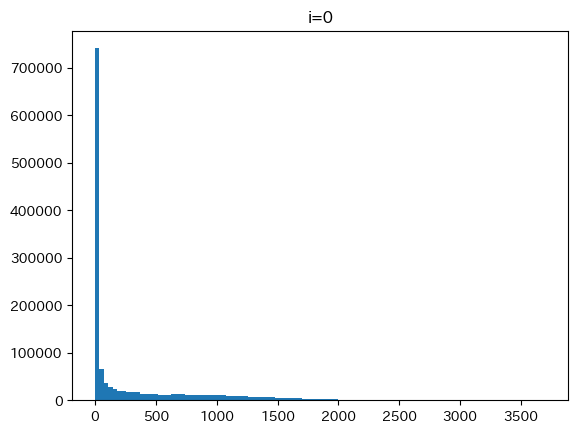

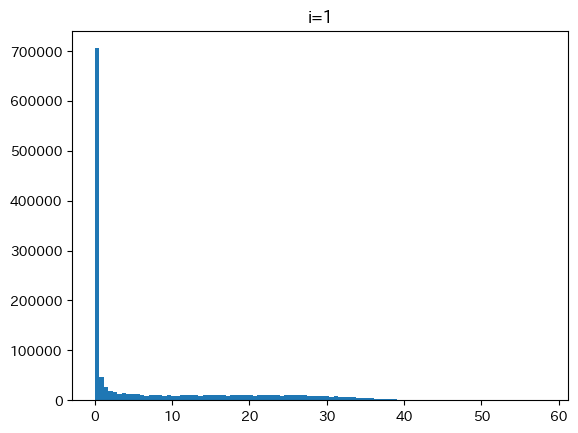

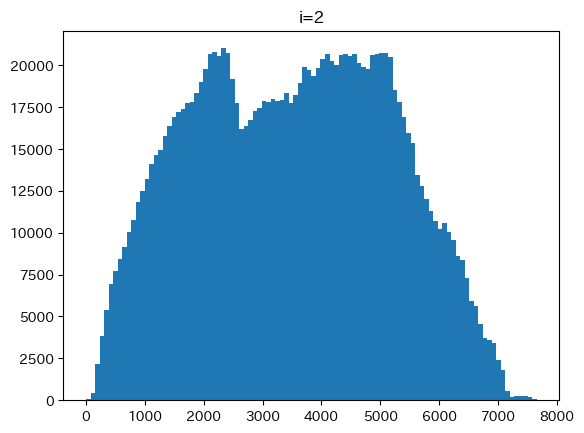

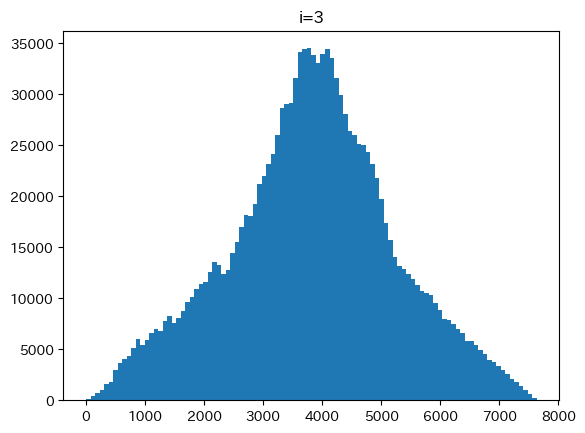

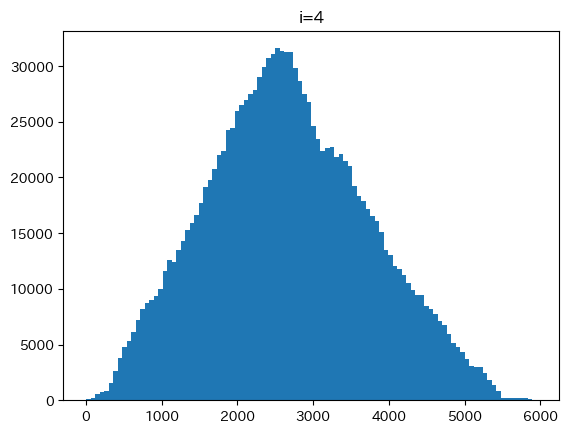

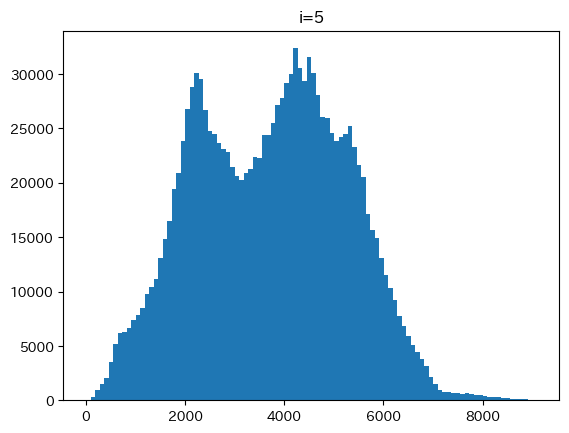

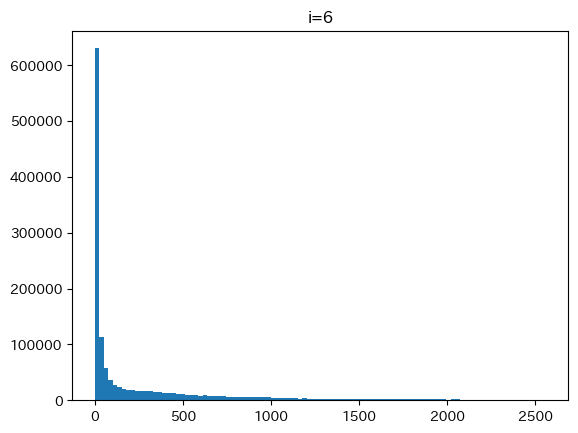

In [30]:
for i in range(W_grids.shape[1]):
    plt.hist(W_grids[:, i], bins=100)
    plt.title(f"i={i}")
    plt.show()

100%|██████████| 2000/2000 [01:48<00:00, 18.52it/s]


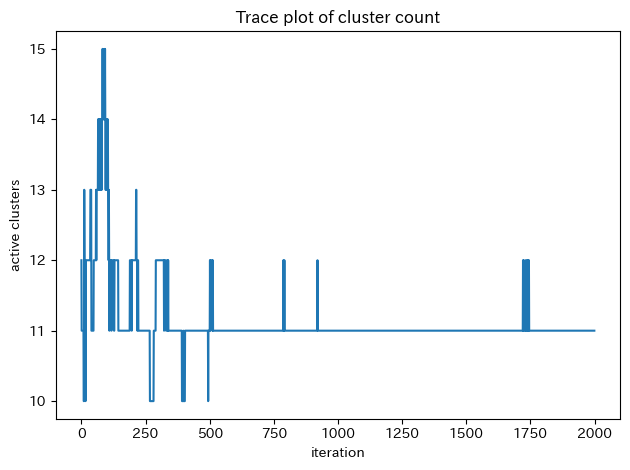

100%|██████████| 10/10 [02:12<00:00, 13.22s/it]
/tmp/ipykernel_770124/2332915989.py:17: RuntimeWarning: invalid value encountered in divide
  ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)


target_period: 0, target_origin: 神津島


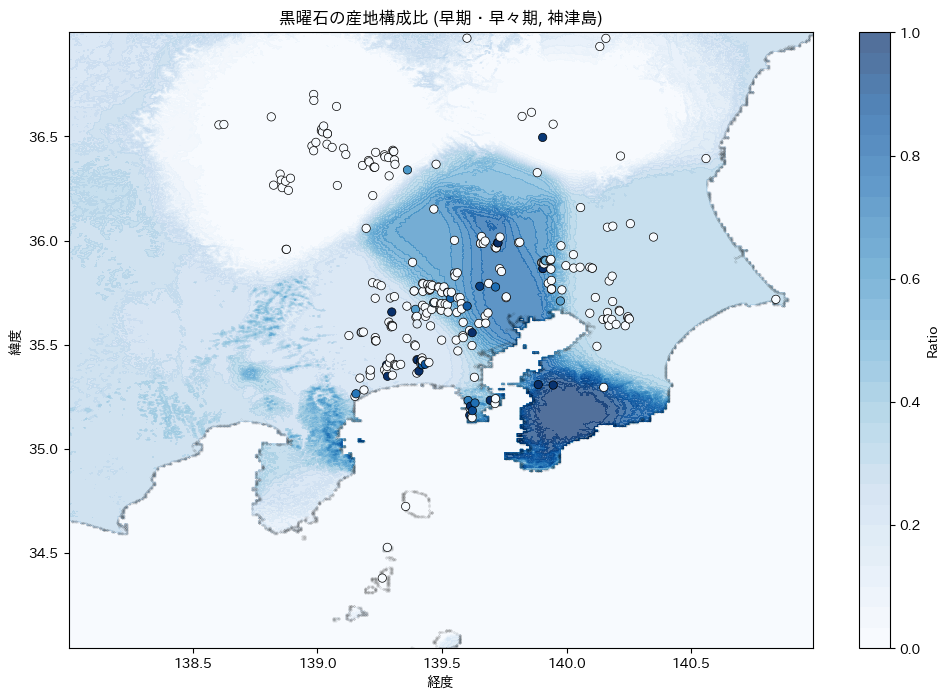

target_period: 0, target_origin: 信州


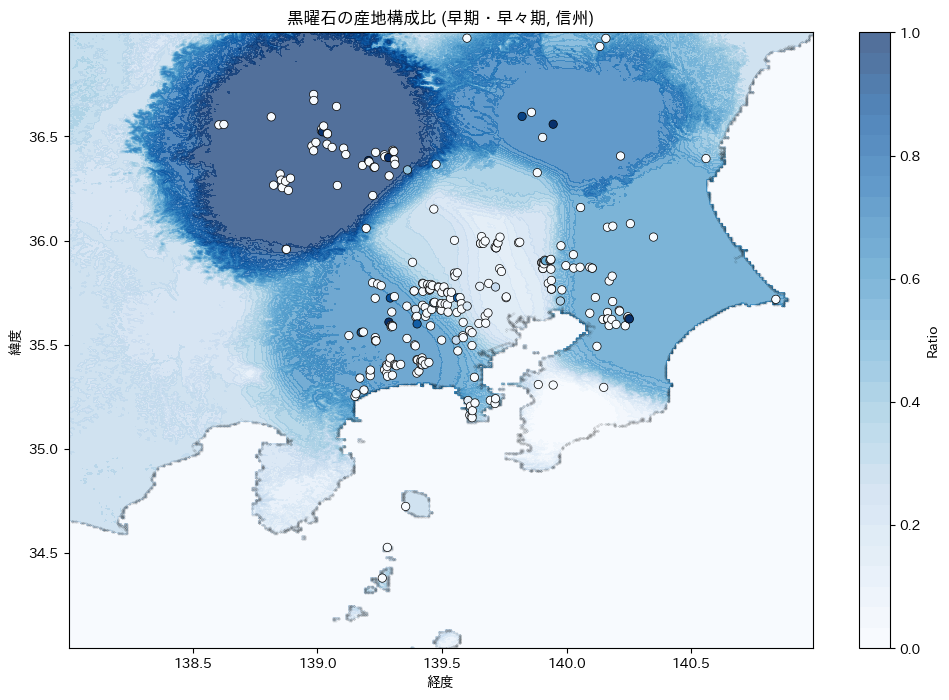

target_period: 0, target_origin: 箱根


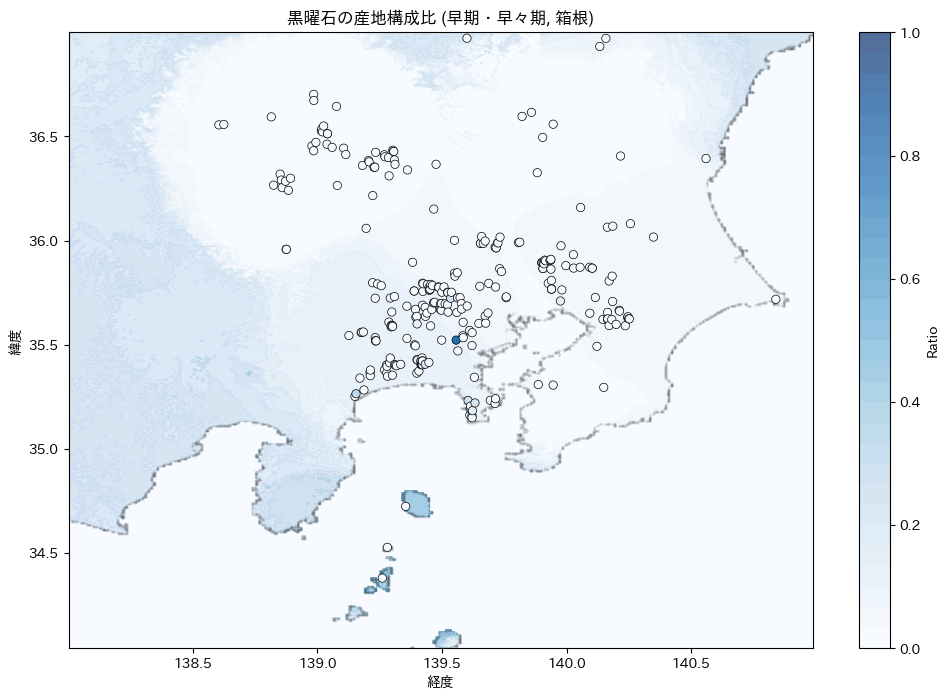

target_period: 0, target_origin: 高原山


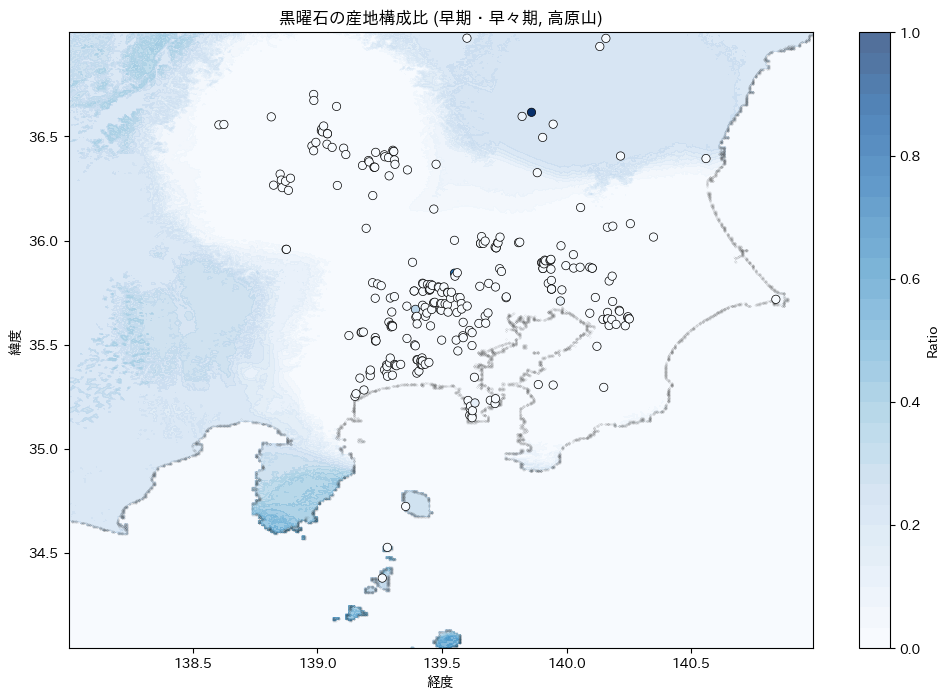

100%|██████████| 2000/2000 [01:49<00:00, 18.34it/s]


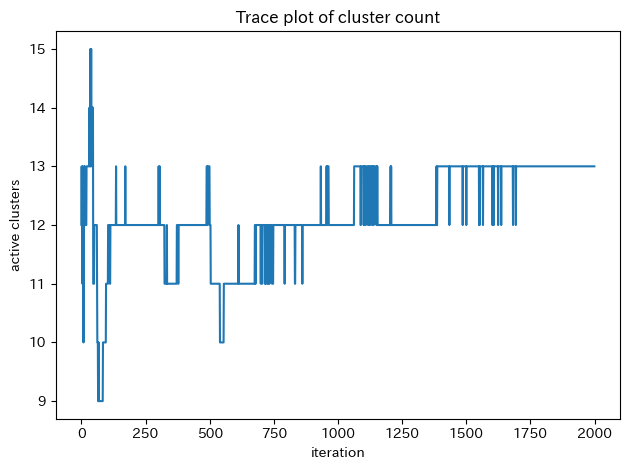

100%|██████████| 10/10 [02:12<00:00, 13.24s/it]


target_period: 0, target_origin: 神津島


ColumnNotFoundError: "比率_0_神津島" not found

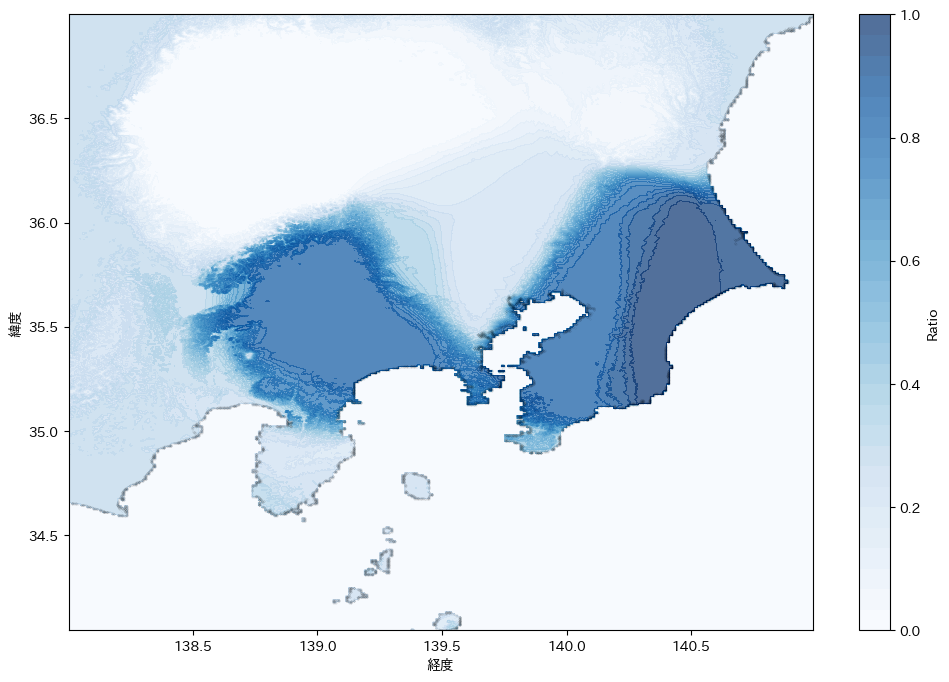

In [31]:
# target_period = 0, 1, 2, 3, 4 で実験

for target_period in range(5):
    counts_all = np.zeros((len(site_coords), len(origin_order) - 1))
    for i, origin in enumerate(origin_order[:-1]):
        counts, target_counts = preprocess_data(df_obsidian, target_period, origin)
        counts_all[:, i] = target_counts

    kappa_coords = 0.002
    kappa_costs = 2
    kappa_elevation = 10000
    kappa_angle = 3
    kappa_river = 2
    gamma = 0.1
    alpha0 = 0.1

    # 1)  学習
    ell = np.array(
        [
            kappa_coords,
            kappa_coords,
            kappa_elevation,
            kappa_angle,
            kappa_costs,
            kappa_costs,
            kappa_costs,
            kappa_costs,
            kappa_river,
        ]
    )

    res = train_ddp(
        X_sites,
        counts_all,
        X_grids,
        ell=ell,  # 初期長さ尺度
        gamma=gamma,
        alpha0=alpha0,
        J_max=80,
        n_iter=2000,
        burnin=100,
        seed=0,
    )

    # ---- trace plot ----
    plt.figure()
    plt.plot(res["trace_clusters"])
    plt.xlabel("iteration")
    plt.ylabel("active clusters")
    plt.title("Trace plot of cluster count")
    plt.tight_layout()
    plt.show()

    # 2)  予測
    # 予測値と 1σ 不確実性を同時取得
    pi_mean, pi_sd = predict_pi_batch(
        X_grids, res, aggregate="mean", return_sd=True, S_reduced=10
    )

    # pi_sd はグリッド×カテゴリの標準偏差行列
    # 最大カテゴリ別 sd マップを見たい場合:
    max_sd = pi_sd.max(1)  # shape (M,)

    for i in range(4):
        fig, ax = plot_result(pi_mean, i, target_period=target_period)
        plt.show()

/tmp/ipykernel_134129/2332915989.py:17: RuntimeWarning: invalid value encountered in divide
  ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)


target_period: 0, target_origin: 神津島


(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': '黒曜石の産地構成比 (早期・早々期, 神津島)'}, xlabel='経度', ylabel='緯度'>)

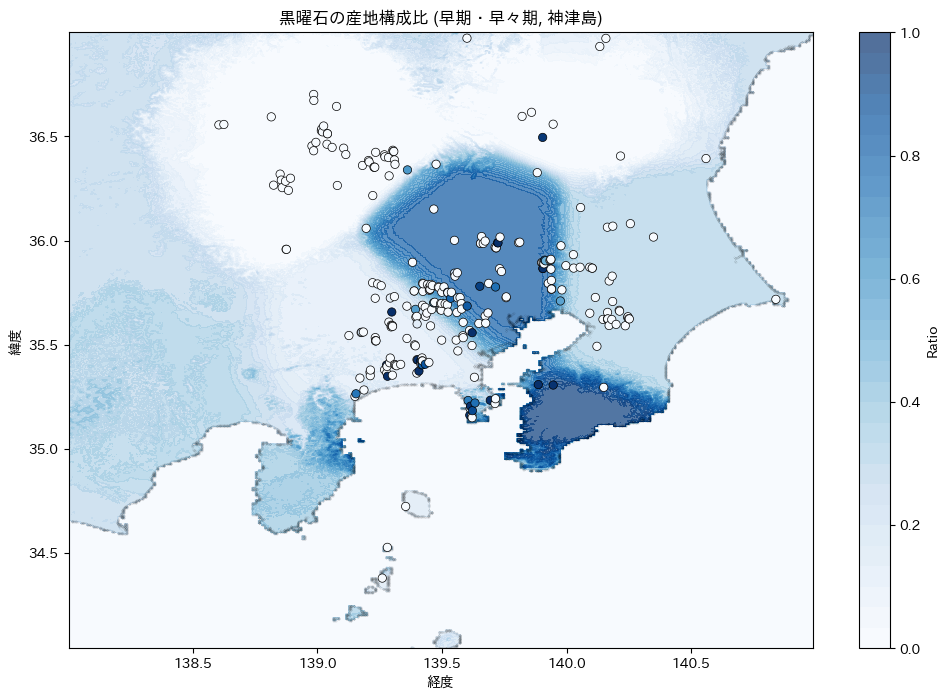

In [ ]:
plot_result(pi_mean, 0, plot_probability=True)

In [ ]:
pi_sd_averaged = pi_sd.mean(axis=1).reshape(pi_mean.shape[0], -1)

/tmp/ipykernel_134129/2332915989.py:17: RuntimeWarning: invalid value encountered in divide
  ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)


target_period: 0, target_origin: 神津島


(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': '事後標準偏差'}, xlabel='経度', ylabel='緯度'>)

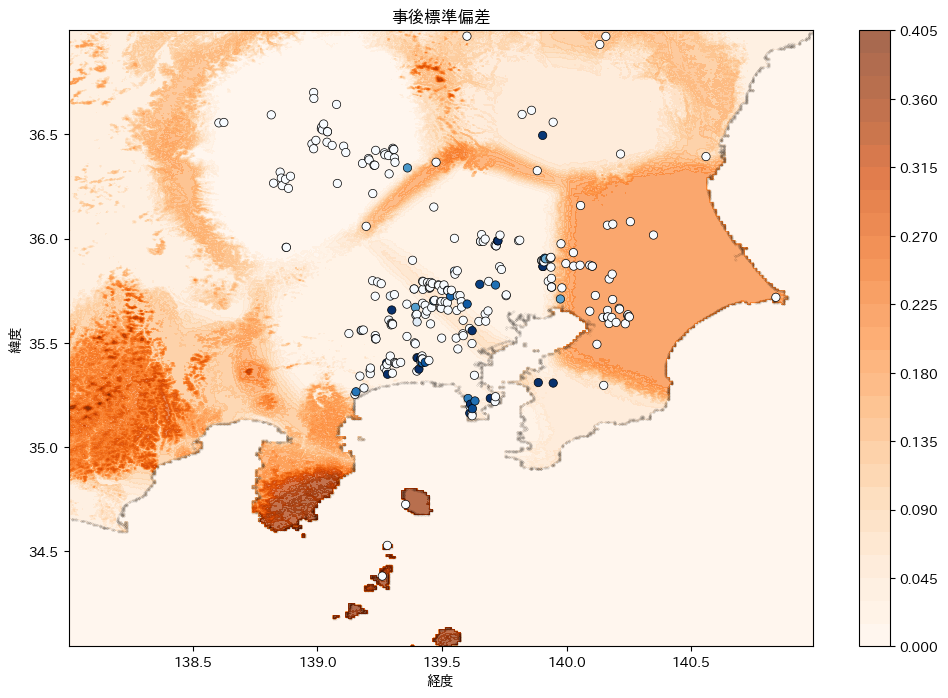

In [ ]:
plot_result(
    pi_sd_averaged, 0, plot_probability=False, cmap="Oranges", title="事後標準偏差"
)

In [ ]:
pi_mean.shape, pi_sd.shape

((1357520, 4), (1357520, 4))